In [1]:
import pandas as pd 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import GroupKFold
from sklearn.inspection import permutation_importance
import numpy as np
import pickle
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
model = joblib.load("q2_pd_model.pkl")
model_no_gmhi = joblib.load("q2_pd_model_no_gmhi.pkl")

In [3]:
shallow = pd.read_csv("Data/calculated_parameters_for_shallow_covid.txt", sep="\t", usecols = [1,2,3,4,5,6,7])
print(shallow.columns)
print(shallow.head())

Index(['Sample', 'Gupta_good', 'Gupta_bad', 'Frac_of_core_functions_among_all',
       'Frac_of_core_functions_found', 'Species_found_together',
       'Contributions_per_species'],
      dtype='object')
              Sample  Gupta_good  Gupta_bad  Frac_of_core_functions_among_all  \
0   100_24122020_S49           0          1                          0.613333   
1   100_29122020_S50           0          1                          0.666667   
2  101k_02122021_S22           1          0                          0.894737   
3  105k_05122021_S24           2          1                          0.958333   
4   108K_08122021_S3           1          2                          0.878571   

   Frac_of_core_functions_found  Species_found_together  \
0                      0.544379                0.000000   
1                      0.142012                0.000000   
2                      0.100592                0.146341   
3                      0.272189                0.146341   
4             

In [4]:
def make_predictions_with_model(loaded_model, input_df, sample_name_col):
    # Assume the target column was dropped earlier, so only features are present in input_df
    # Sample names are stored in 'sample_name_col'
    
    # Make predictions using the loaded model
    # For classification problems, we often use 'predict_proba' for probabilities (scores)
    prediction_scores = loaded_model.predict_proba(input_df)

    # Create a DataFrame with the scores and sample names
    scores_df = pd.DataFrame(prediction_scores, columns=['Q2PD', 'Class_1_Score'])

    return scores_df['Q2PD'].to_frame()

# Example usage:
# loaded_model is the Random Forest model you've loaded earlier
# input_df is your dataframe with features for each sample, and 'sample_name' contains sample names
scores_df = make_predictions_with_model(model, shallow.iloc[:,1:], sample_name_col='Sample')
scores_df['Sample'] = list(shallow['Sample'])
print(scores_df)

         Q2PD             Sample
0    0.710126   100_24122020_S49
1    0.815929   100_29122020_S50
2    0.623837  101k_02122021_S22
3    0.532347  105k_05122021_S24
4    0.679009   108K_08122021_S3
..        ...                ...
331  0.637704   K48_30092021_S42
332  0.729437    K49_01102021_S7
333  0.728877   K49_29092021_S13
334  0.658785   K50_28092021_S41
335  0.653340    K6_17092021_S39

[336 rows x 2 columns]


(122, 3)


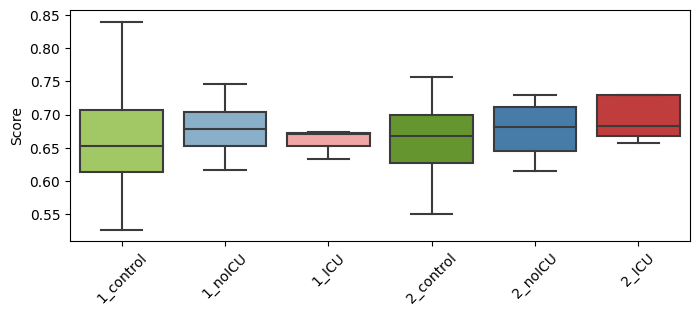

In [5]:
meta= pd.read_csv("Data/metadata_covid_shallow.txt", sep="\t", usecols=[0,1])

merged_df = scores_df.merge(meta, left_on='Sample', right_on='Sample', how='inner')
print(merged_df.shape)
merged_df = merged_df.dropna()


scores_pred_df = pd.DataFrame()
scores_pred_df['SampleID'] = list(merged_df['Sample'])
scores_pred_df['Score'] = list(merged_df['Q2PD'])
scores_pred_df['Category'] = list(merged_df['Diagnosis'])

scores_pred_df['Category'] = scores_pred_df['Category'].replace("Case_first_ICU","1_ICU")
scores_pred_df['Category'] = scores_pred_df['Category'].replace("Case_last_ICU","2_ICU")
scores_pred_df['Category'] = scores_pred_df['Category'].replace("Case_first_noICU","1_noICU")
scores_pred_df['Category'] = scores_pred_df['Category'].replace("Case_last_noICU","2_noICU")
scores_pred_df['Category'] = scores_pred_df['Category'].replace("Control_first","1_control")
scores_pred_df['Category'] = scores_pred_df['Category'].replace("Control_last","2_control")

scores_pred_df['Category'] = pd.Categorical(scores_pred_df['Category'], ["1_control", "1_noICU", "1_ICU","2_control", "2_noICU", "2_ICU"])
scores_pred_df = scores_pred_df.sort_values(by="Category")

my_pal = {"1_control":sns.color_palette("Set2")[4], "2_control":sns.color_palette("Dark2")[4], "1_noICU":sns.color_palette("Set3")[4],"2_noICU":sns.color_palette("Set1")[1], "1_ICU":sns.color_palette("Paired")[4], "2_ICU":sns.color_palette("tab20")[6]}

plt.figure(figsize=(8,3))
ax = sns.boxplot(data=scores_pred_df, x='Category', y="Score", palette = my_pal, fliersize=0)
#add_stat_annotation(ax, data=scores_pred_df, x="Category", y="Score", box_pairs=[(("1_ICU"), ("2_ICU")),(("2_noICU"), ("2_ICU")),(("1_control"), ("2_ICU"))],test='t-test_ind', text_format='star', loc='inside',verbose=0)

plt.xticks(rotation=45)
plt.xlabel("")
plt.show()

In [6]:
deep = pd.read_csv("Data/calculated_parameters_for_deep_covid.txt", sep="\t", usecols = [1,2,3,4,5,6,7])
print(deep.columns)
print(deep.head())

Index(['Sample', 'Gupta_good', 'Gupta_bad', 'Frac_of_core_functions_among_all',
       'Frac_of_core_functions_found', 'Species_found_together',
       'Contributions_per_species'],
      dtype='object')
     Sample  Gupta_good  Gupta_bad  Frac_of_core_functions_among_all  \
0   128_S58           0          1                          0.489231   
1   131_S59           0          0                          0.844828   
2    34_S17           1          4                          0.814208   
3    35_S18           1          3                          0.867021   
4  670_S246           2          2                          0.814433   

   Frac_of_core_functions_found  Species_found_together  \
0                      0.940828                0.000000   
1                      0.579882                0.000000   
2                      0.881657                0.268293   
3                      0.964497                0.268293   
4                      0.934911                0.731707   

   Contr

In [7]:
scores_df = make_predictions_with_model(model, deep.iloc[:,1:], sample_name_col='Sample')
scores_df['Sample'] = list(deep['Sample'])
print(scores_df)

        Q2PD    Sample
0   0.645782   128_S58
1   0.660912   131_S59
2   0.651063    34_S17
3   0.640722    35_S18
4   0.501730  670_S246
5   0.566838  681_S255
6   0.483532  691_S264
7   0.546254  700_S270
8   0.591662  701_S271
9   0.592658  740_S295
10  0.627630  742_S296
11  0.572036  842_S348
12  0.682796  890_S376


       Q2PD    Sample  Diagnosis
0  0.645782   128_S58  First_ICU
1  0.660912   131_S59   Last_ICU
2  0.651063    34_S17  First_ICU
3  0.640722    35_S18   Last_ICU
4  0.501730  670_S246  First_ICU


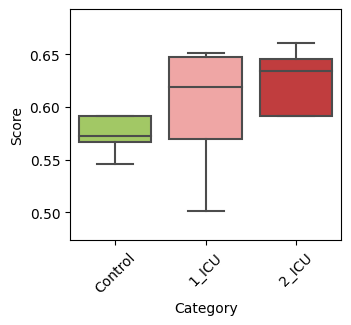

In [8]:
meta= pd.read_csv("Data/metadata_covid_deep.txt", sep="\t", usecols=[0,1])

merged_df = scores_df.merge(meta, left_on='Sample', right_on='Sample', how='inner')
print(merged_df.head())
merged_df = merged_df.dropna()
merged_df = merged_df.replace(['Healthy'], ['Control'])
merged_df = merged_df.replace(['First_ICU'], ['Case_first_ICU'])
merged_df = merged_df.replace(['Last_ICU'], ['Case_last_ICU'])

scores_pred_df = pd.DataFrame()
scores_pred_df['SampleID'] = list(merged_df['Sample'])
scores_pred_df['Score'] = list(merged_df['Q2PD'])
scores_pred_df['Category'] = list(merged_df['Diagnosis'])

scores_pred_df['Category'] = scores_pred_df['Category'].replace("Case_first_ICU","1_ICU")
scores_pred_df['Category'] = scores_pred_df['Category'].replace("Case_last_ICU","2_ICU")
scores_pred_df['Category'] = scores_pred_df['Category'].replace("Case_first_noICU","1_noICU")
scores_pred_df['Category'] = scores_pred_df['Category'].replace("Case_last_noICU","2_noICU")


scores_pred_df['Category'] = pd.Categorical(scores_pred_df['Category'], ["Control", "1_ICU", "2_ICU"])
scores_pred_df = scores_pred_df.sort_values(by="Category")

my_pal = {"Control":sns.color_palette("Set2")[4], "2_control":sns.color_palette("Dark2")[4], "1_noICU":sns.color_palette("Set3")[4],"2_noICU":sns.color_palette("Set1")[1], "1_ICU":sns.color_palette("Paired")[4], "2_ICU":sns.color_palette("tab20")[6]}

plt.figure(figsize=(3.5,3))
ax = sns.boxplot(data=scores_pred_df, x='Category', y="Score", palette = my_pal, fliersize=0)
#add_stat_annotation(ax, data=scores_pred_df, x="Category", y="Score", box_pairs=[(("1_ICU"), ("2_ICU")),(("2_noICU"), ("2_ICU")),(("1_control"), ("2_ICU"))],test='t-test_ind', text_format='star', loc='inside',verbose=0)

plt.xticks(rotation=45)
plt.show()

In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

# Load your deep dataset
deep = pd.read_csv("Data/calculated_parameters_for_deep_covid.txt", sep="\t", usecols=[1, 2, 3, 4, 5, 6, 7])


# Load metadata and merge
meta = pd.read_csv("Data/metadata_covid_deep.txt", sep="\t", usecols=[0, 1])
merged_df = deep.merge(meta, left_on='Sample', right_on='Sample', how='inner').drop('Sample', axis=1)

# Clean the merged dataframe
merged_df = merged_df.dropna()
merged_df = merged_df.replace(['Healthy'], 1)
merged_df = merged_df.replace(['First_ICU'], 0)
merged_df = merged_df.replace(['Last_ICU'], 0)


# Set up the color palette
my_pal = {
    "Control": sns.color_palette("Set2")[4], 
    "2_control": sns.color_palette("Dark2")[4], 
    "1_noICU": sns.color_palette("Set3")[4],
    "2_noICU": sns.color_palette("Set1")[1], 
    "1_ICU": sns.color_palette("Paired")[4], 
    "2_ICU": sns.color_palette("tab20")[6]
}


# Calculate and print permutation feature importance
def calculate_permutation_importance(model, input_df, target_col):
    # Prepare features and target variable
    X = input_df.drop(columns=[target_col])
    y = input_df[target_col]

    # Calculate permutation importance
    perm_importance = permutation_importance(model, X, y, n_repeats=10, random_state=42)

    # Create a DataFrame for permutation importance results
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': perm_importance.importances_mean
    }).sort_values(by='Importance', ascending=False)

    print("Permutation-based Feature Importances:")
    print(importance_df)

# Call the function to calculate and print permutation feature importance
calculate_permutation_importance(model, merged_df, 'Diagnosis')

Permutation-based Feature Importances:
                            Feature  Importance
4            Species_found_together    0.153846
2  Frac_of_core_functions_among_all    0.015385
5         Contributions_per_species    0.007692
3      Frac_of_core_functions_found    0.000000
0                        Gupta_good   -0.023077
1                         Gupta_bad   -0.161538


       Q2PD    Sample  Diagnosis
0  0.565458   128_S58  First_ICU
1  0.521480   131_S59   Last_ICU
2  0.691455    34_S17  First_ICU
3  0.622356    35_S18   Last_ICU
4  0.510694  670_S246  First_ICU


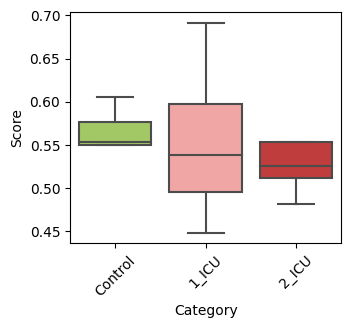

In [63]:
### make predictions with a model without GMHI parameters

deep = pd.read_csv("Data/calculated_parameters_for_deep_covid.txt", sep="\t", usecols = [1,4,5,6,7])
scores_df = make_predictions_with_model(model_no_gmhi, deep.iloc[:,1:], sample_name_col='Sample')
scores_df['Sample'] = list(deep['Sample'])
meta= pd.read_csv("Data/metadata_covid_deep.txt", sep="\t", usecols=[0,1])

merged_df = scores_df.merge(meta, left_on='Sample', right_on='Sample', how='inner')
print(merged_df.head())
merged_df = merged_df.dropna()
merged_df = merged_df.replace(['Healthy'], ['Control'])
merged_df = merged_df.replace(['First_ICU'], ['Case_first_ICU'])
merged_df = merged_df.replace(['Last_ICU'], ['Case_last_ICU'])

scores_pred_df = pd.DataFrame()
scores_pred_df['SampleID'] = list(merged_df['Sample'])
scores_pred_df['Score'] = list(merged_df['Q2PD'])
scores_pred_df['Category'] = list(merged_df['Diagnosis'])

scores_pred_df['Category'] = scores_pred_df['Category'].replace("Case_first_ICU","1_ICU")
scores_pred_df['Category'] = scores_pred_df['Category'].replace("Case_last_ICU","2_ICU")
scores_pred_df['Category'] = scores_pred_df['Category'].replace("Case_first_noICU","1_noICU")
scores_pred_df['Category'] = scores_pred_df['Category'].replace("Case_last_noICU","2_noICU")


scores_pred_df['Category'] = pd.Categorical(scores_pred_df['Category'], ["Control", "1_ICU", "2_ICU"])
scores_pred_df = scores_pred_df.sort_values(by="Category")

my_pal = {"Control":sns.color_palette("Set2")[4], "2_control":sns.color_palette("Dark2")[4], "1_noICU":sns.color_palette("Set3")[4],"2_noICU":sns.color_palette("Set1")[1], "1_ICU":sns.color_palette("Paired")[4], "2_ICU":sns.color_palette("tab20")[6]}

plt.figure(figsize=(3.5,3))
ax = sns.boxplot(data=scores_pred_df, x='Category', y="Score", palette = my_pal, fliersize=0)
#add_stat_annotation(ax, data=scores_pred_df, x="Category", y="Score", box_pairs=[(("1_ICU"), ("2_ICU")),(("2_noICU"), ("2_ICU")),(("1_control"), ("2_ICU"))],test='t-test_ind', text_format='star', loc='inside',verbose=0)

plt.xticks(rotation=45)
plt.show()

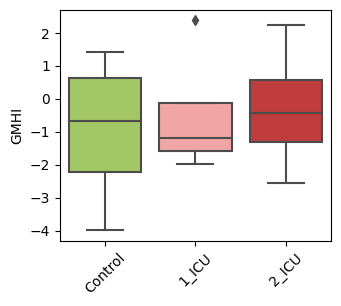

In [67]:
### gmhi

data = pd.read_csv('Data/covid_gmhi_scores.txt', sep="\t")
data.columns = ['Diagnosis','GMHI']

scores_pred_df = pd.DataFrame()
scores_pred_df['Score'] = list(data['GMHI'])
scores_pred_df['Category'] = list(data['Diagnosis'])

scores_pred_df['Category'] = scores_pred_df['Category'].replace("Case_first_ICU","1_ICU")
scores_pred_df['Category'] = scores_pred_df['Category'].replace("Case_last_ICU","2_ICU")
scores_pred_df['Category'] = scores_pred_df['Category'].replace("Case_first_noICU","1_noICU")
scores_pred_df['Category'] = scores_pred_df['Category'].replace("Case_last_noICU","2_noICU")


scores_pred_df['Category'] = pd.Categorical(scores_pred_df['Category'], ["Control", "1_ICU", "2_ICU"])
scores_pred_df = scores_pred_df.sort_values(by="Category")

my_pal = {"Control":sns.color_palette("Set2")[4], "2_control":sns.color_palette("Dark2")[4], "1_noICU":sns.color_palette("Set3")[4],"2_noICU":sns.color_palette("Set1")[1], "1_ICU":sns.color_palette("Paired")[4], "2_ICU":sns.color_palette("tab20")[6]}

plt.figure(figsize=(3.5,3))
ax = sns.boxplot(data=scores_pred_df, x='Category', y="Score", palette = my_pal)
#add_stat_annotation(ax, data=scores_pred_df, x="Category", y="Score", box_pairs=[(("1_ICU"), ("2_ICU")),(("2_noICU"), ("2_ICU")),(("1_control"), ("2_ICU"))],test='t-test_ind', text_format='star', loc='inside',verbose=0)

plt.xticks(rotation=45)
plt.ylabel("GMHI")
plt.xlabel("")
plt.show()

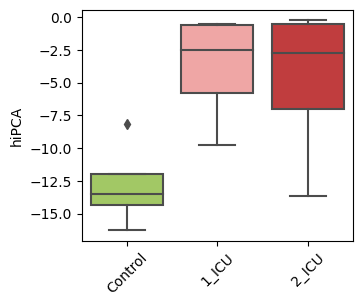

In [68]:
### hipca

data = pd.read_csv('Data/covid_hipca_scores.txt', sep="\t")
data.columns = ['hiPCA','Diagnosis']

scores_pred_df = pd.DataFrame()
scores_pred_df['Score'] = list(data['hiPCA'])
scores_pred_df['Category'] = list(data['Diagnosis'])

scores_pred_df['Category'] = scores_pred_df['Category'].replace("Case_first_ICU","1_ICU")
scores_pred_df['Category'] = scores_pred_df['Category'].replace("Case_last_ICU","2_ICU")
scores_pred_df['Category'] = scores_pred_df['Category'].replace("Case_first_noICU","1_noICU")
scores_pred_df['Category'] = scores_pred_df['Category'].replace("Case_last_noICU","2_noICU")


scores_pred_df['Category'] = pd.Categorical(scores_pred_df['Category'], ["Control", "1_ICU", "2_ICU"])
scores_pred_df = scores_pred_df.sort_values(by="Category")

my_pal = {"Control":sns.color_palette("Set2")[4], "2_control":sns.color_palette("Dark2")[4], "1_noICU":sns.color_palette("Set3")[4],"2_noICU":sns.color_palette("Set1")[1], "1_ICU":sns.color_palette("Paired")[4], "2_ICU":sns.color_palette("tab20")[6]}

plt.figure(figsize=(3.5,3))
ax = sns.boxplot(data=scores_pred_df, x='Category', y="Score", palette = my_pal)

plt.xticks(rotation=45)
plt.xlabel("")
plt.ylabel("hiPCA")
plt.show()